In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, accuracy_score
import xgboost as xgb
import pickle

In [7]:
path = 'datacountstudents.csv'
data = pd.read_csv(path, sep = ',', na_filter = False)
data = data.set_index('id')
X_train = data.drop(columns = ['yC']).copy()
y_train = data[['yC']].copy()

In [8]:
X_train.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32
id,,,,,,,,,,,,,,,,,,,,,
1,49.856,118.8,1,0,0,0,0,16.32096,0,18.762237,...,0.9709,0.0003,6,6,24.7138,0,0,7,0.056546,0.112860
2,71.836,34.8,0,0,0,0,1,15.00535,44,119.946790,...,0.4200,0.0000,8,4,38.0658,0,0,7,0.655260,0.886908
3,66.725,41.8,0,1,0,0,0,17.07023,27,10.879595,...,0.9650,0.0000,6,6,48.3807,0,1,4,0.067855,0.133944
4,41.696,132.0,0,0,1,0,0,16.31460,0,9.762927,...,0.0091,0.0001,6,4,59.8410,0,0,7,0.133230,0.260102
5,71.351,24.2,1,0,0,0,0,11.10790,31,151.581820,...,0.0051,0.0000,5,7,175.9250,0,0,3,0.318584,0.627729


In [9]:
def calculated_metrics(variablesSelected,X_trained_scaled,y_train,X_test_scaled,y_test):
    X_trained_scaled_aux = X_trained_scaled[variablesSelected].copy()
    X_test_scaled_aux = X_test_scaled[variablesSelected].copy()
    regr = xgb.XGBRegressor(objective ='reg:squarederror')

    # Train the model using the training sets
    regr.fit(X_trained_scaled_aux,  y_train['yC'].values)

    # Make predictions using the testing set
    y_pred = regr.predict(X_test_scaled_aux)

    y_pred = pd.DataFrame(y_pred, index=y_test.index, columns=["y_pred"])
    y_pred = np.round(y_pred)

    total = y_pred.join(y_test)
    total['y_igual_0'] = (total['yC'] == 0).astype(int)
    total['y_pred_igual_0'] = (total['y_pred'] == 0).astype(int)
    total['good_class'] = (total['y_igual_0']==total['y_pred_igual_0']).astype(int)
    mse = mean_squared_error(y_test, y_pred)
    accuray = accuracy_score(total['y_igual_0'], total['y_pred_igual_0']) 
    return mse,accuray

In [10]:
modelToProof = [['x4', 'x13', 'x25', 'x24', 'x27', 'x7', 'x14', 'x3', 'x2', 'x8', 'x22']]

In [22]:
resultados =  pd.DataFrame()
mse_total =  pd.DataFrame()
accuracy_total =  pd.DataFrame()
for variablesTorun in modelToProof:
    print(variablesTorun)
    mse = []
    accuray = []
    if len(variablesTorun)>0:
        for j in range(1,100):
            X_train_aux, X_test_aux, y_train_aux, y_test_aux = train_test_split(X_train, y_train, test_size=0.2)
            standarscaler = StandardScaler()
            X_trained_scaled_aux = standarscaler.fit_transform(X_train_aux)
            X_trained_scaled_aux = pd.DataFrame(X_trained_scaled_aux, index=X_train_aux.index, columns=X_train_aux.columns.values)

            X_test_scaled_aux = standarscaler.transform(X_test_aux)

            X_test_scaled_aux = pd.DataFrame(X_test_scaled_aux, index=X_test_aux.index, columns=X_test_aux.columns.values)

            variablesSelected = list(variablesTorun)
            mse_aux,accuray_aux= calculated_metrics(variablesSelected,X_trained_scaled_aux,y_train_aux,X_test_scaled_aux,y_test_aux)
            mse.append(mse_aux)
            accuray.append(accuray_aux)


        auxRes= pd.DataFrame({'Modelo': [variablesTorun], 'Median: Mean squared error': [np.median(np.asarray(mse))],'Median: Accuray': [np.median(np.asarray(accuray))]})
        resultados = pd.concat([resultados,auxRes])
        name = ','.join(variablesTorun)

        mse_total[name] = mse
        accuracy_total[name] = accuray
#         break
#         resultados.to_csv('ResultadosCV_scores.csv')
    else:
        print(f"El conjunto de variables {variablesTorun} no tiene variables")
#     break
# resultado_scores_ranking_cv.reset_index(inplace = True,drop = True)

['x4', 'x13', 'x25', 'x24', 'x27', 'x7', 'x14', 'x3', 'x2', 'x8', 'x22']


In [23]:
resultados.sort_values('Median: Mean squared error')

,Median: Accuray,Median: Mean squared error,Modelo
0,0.633333,1.433333,"[x4, x13, x25, x24, x27, x7, x14, x3, x2, x8, ..."


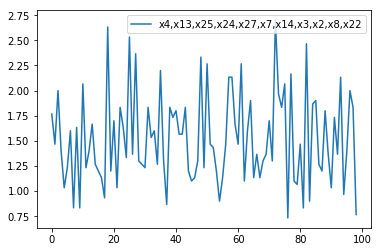

In [24]:
mse_total.plot()

In [25]:
mse_total.describe().T

,count,mean,std,min,25%,50%,75%,max
"x4,x13,x25,x24,x27,x7,x14,x3,x2,x8,x22",99.0,1.522559,0.451473,0.733333,1.2,1.433333,1.833333,2.7


In [17]:
def training_model(variablesSelected,X_trained,y_train,X_test,y_test):
    X_trained_aux = X_trained[variablesSelected].copy()
    X_test_aux = X_test[variablesSelected].copy()
    ## Regresion para cada cantidad de variables
    model_to_return = {}
    model_to_return['variableSelected'] = variablesSelected
    
    pipeline = Pipeline(steps = [('standarscaled',StandardScaler()),
                                 ('xgboost',xgb.XGBRegressor(objective ='reg:squarederror'))])


    # Train the model using the training sets
    pipeline.fit(X_trained_aux,  y_train['yC'].values)

    # Make predictions using the testing set
    y_pred = pipeline.predict(X_test_aux)

    y_pred = pd.DataFrame(y_pred, index=y_test.index, columns=["y_pred"])
    y_pred = np.round(y_pred)

    total = y_pred.join(y_test)
    total['y_igual_0'] = (total['yC'] == 0).astype(int)
    total['y_pred_igual_0'] = (total['y_pred'] == 0).astype(int)
    total['good_class'] = (total['y_igual_0']==total['y_pred_igual_0']).astype(int)
    mse = mean_squared_error(y_test, y_pred)
    accuray = accuracy_score(y_test, y_pred) #total['good_class'].sum()/len(total)
    model_to_return['model'] = pipeline
    model_to_return['mse_test'] = mse
    model_to_return['accuray_test'] = accuray
    return model_to_return

## Modelo Final

In [ ]:
variablesSelected = ['x4', 'x13', 'x25', 'x24', 'x27', 'x7', 'x14', 'x3', 'x2', 'x8', 'x22']

In [ ]:
model_to_return = training_model(variablesSelected,X_train,y_train,X_test,y_test)

In [ ]:
model_to_return

In [ ]:
pickle.dump(model_to_return, open('modelCount.sav', 'wb'))